## **Computing Risk Parity Portfolio Weights**
*Authours: Madina Kudaibergenova and Madina Saparbayeva*

**Roadmap:** 
- Apply hierarchical clustering first
- Build a portfolio by picking one asset from each cluster (with equal weight),
- Compare this portfolio's risk with traditional methodologies for optimized portfolio.

<br>

**Data:** 10 assets   
["FB", "AMZN", "AAPL", "GOOG", "NFLX", "TSLA", "MSFT", "IBM", "ORCL", "ADBE"]

<br>

**Date:** almost 3 years   
[2019-01-04] to [2021-04-23]

<br>

**Results:**  
**Maximum Optimized Sharpe Ratio**  
Expected annual return : 98.0%  
Annual volatility/standard deviation/risk : 48.0%  
Annual variance : 23.0%  
<br>
**Sharpe Ratio Second Method**  
Expected annual return : 68.0%  
Annual volatility/standard deviation/risk : 35.0%  
Annual variance : 12.0%  
<br>
**HRP results**  
Expected annual return : 37.0%  
Annual volatility/standard deviation/risk : 31.0%  
Annual variance : 10.0%  

<br>

##Data Storage and Representation

In [ ]:
# Import the python libraries
from pandas_datareader import data as web
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tnrange, tqdm_notebook, tqdm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.covariance import shrunk_covariance, ledoit_wolf, OAS, MinCovDet

In [ ]:
#change it to need one 
assets =  ["FB", "AMZN", "AAPL", "GOOG", "NFLX", "TSLA", "MSFT", "IBM", "ORCL", "ADBE"]

In [ ]:
# Assign weights to the stocks. Weights must = 1 so 0.1 for each
weights = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
weights

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [ ]:
#Get the stock starting date and ending date in cvs files.
stockStartDate = '2019-01-04'
stockEndDate = '2021-04-23'

In [ ]:
#Create a dataframe to store the close price of the stocks
close_prices = pd.DataFrame()

#Store the close price of stock into the data frame
for stock in assets:
   close_prices[stock] = web.DataReader(stock,data_source='yahoo',start=stockStartDate, end = stockEndDate)['Close']

returns = close_prices.pct_change()
close_prices

,FB,AMZN,AAPL,GOOG,NFLX,TSLA,MSFT,IBM,ORCL,ADBE
Date,,,,,,,,,,
2019-01-04,137.949997,1575.390015,37.064999,1070.709961,297.570007,63.537998,101.930000,117.320000,46.709999,226.190002
2019-01-07,138.050003,1629.510010,36.982498,1068.390015,315.339996,66.991997,102.059998,118.150002,47.450001,229.259995
2019-01-08,142.529999,1656.579956,37.687500,1076.280029,320.269989,67.070000,102.800003,119.830002,47.880001,232.679993
2019-01-09,144.229996,1659.420044,38.327499,1074.660034,319.959991,67.706001,104.269997,120.690002,47.779999,235.429993
2019-01-10,144.199997,1656.219971,38.450001,1070.329956,324.660004,68.994003,103.599998,121.790001,47.820000,237.770004
...,...,...,...,...,...,...,...,...,...,...
2021-04-19,302.239990,3372.010010,134.839996,2302.399902,554.440002,714.630005,258.739990,133.119995,78.750000,516.169983
2021-04-20,302.649994,3334.689941,133.110001,2293.629883,549.570007,718.989990,258.260010,138.160004,79.239998,514.210022
2021-04-21,301.470001,3362.020020,133.500000,2293.290039,508.899994,744.119995,260.579987,143.550003,76.660004,512.340027


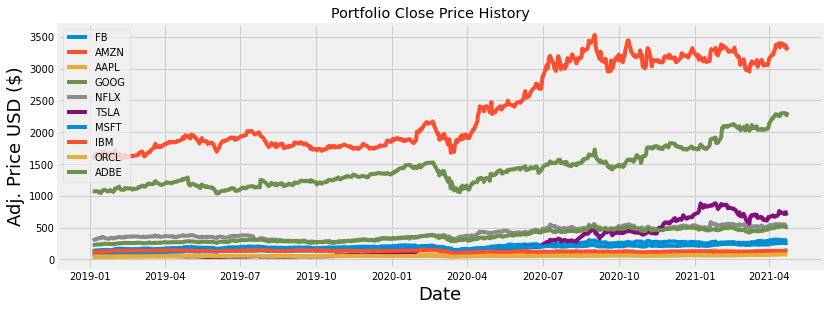

In [ ]:
# Create the title 'Portfolio Close Price History
title = 'Portfolio Close Price History    '
#Get the stocks
my_stocks = close_prices
#Create and plot the graph
plt.figure(figsize=(12.2,4.5)) #width = 12.2in, height = 4.5
# Loop through each stock and plot the Close for each day
for c in my_stocks.columns.values:
  plt.plot( my_stocks[c],  label=c)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)
plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Adj. Price USD ($)',fontsize=18)
plt.legend(my_stocks.columns.values, loc='upper left')
plt.show()# Create the title 'Portfolio Close Price History
title = 'Portfolio Close Price History    '

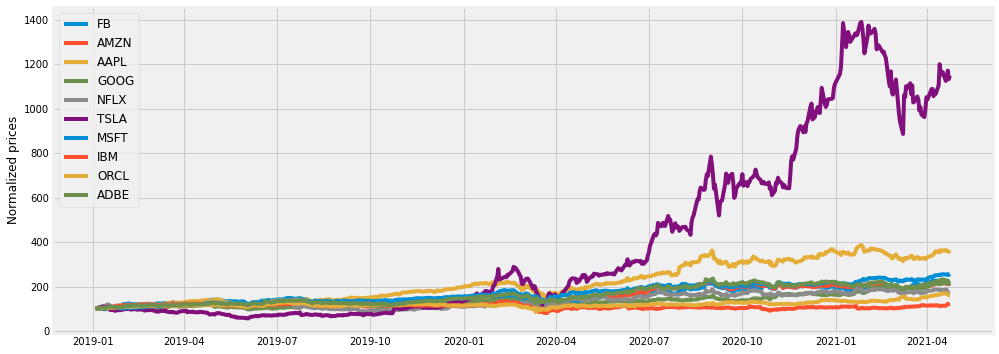

In [ ]:
#Create normalized plot too see the variance of prices 
normalized_prices = close_prices.divide(close_prices.iloc[0] / 100)

plt.figure(figsize=(15, 6))
for i in range(normalized_prices.shape[1]):
    plt.plot(normalized_prices.iloc[:,i], label=normalized_prices.columns.values[i])
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Normalized prices')
plt.show()

##Financial Calculation

In [ ]:
returns

,FB,AMZN,AAPL,GOOG,NFLX,TSLA,MSFT,IBM,ORCL,ADBE
Date,,,,,,,,,,
2019-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,0.000725,0.034353,-0.002226,-0.002167,0.059717,0.054361,0.001275,0.007075,0.015842,0.013573
2019-01-08,0.032452,0.016612,0.019063,0.007385,0.015634,0.001164,0.007251,0.014219,0.009062,0.014918
2019-01-09,0.011927,0.001714,0.016982,-0.001505,-0.000968,0.009483,0.014300,0.007177,-0.002089,0.011819
2019-01-10,-0.000208,-0.001928,0.003196,-0.004029,0.014689,0.019023,-0.006426,0.009114,0.000837,0.009939
...,...,...,...,...,...,...,...,...,...,...
2021-04-19,-0.012868,-0.008069,0.005069,0.002019,0.014455,-0.033997,-0.007670,-0.003518,-0.002533,-0.016969
2021-04-20,0.001357,-0.011068,-0.012830,-0.003809,-0.008784,0.006101,-0.001855,0.037861,0.006222,-0.003797
2021-04-21,-0.003899,0.008196,0.002930,-0.000148,-0.074003,0.034952,0.008983,0.039013,-0.032559,-0.003637


In [ ]:
#co-variance matrix to see the how much two variables vary or move together
#diagonal values are variance and others are co-variance
cov_matrix_annual = returns.cov() * 252 # 252 - the working day in year
cov_matrix_annual

,FB,AMZN,AAPL,GOOG,NFLX,TSLA,MSFT,IBM,ORCL,ADBE
FB,0.136993,0.075781,0.093251,0.084395,0.078464,0.096922,0.084738,0.046443,0.056043,0.095403
AMZN,0.075781,0.094681,0.075674,0.063084,0.079560,0.095435,0.073591,0.036942,0.041996,0.081004
AAPL,0.093251,0.075674,0.132655,0.078060,0.075639,0.119829,0.093650,0.056984,0.063426,0.094825
GOOG,0.084395,0.063084,0.078060,0.099640,0.065442,0.087563,0.080954,0.052134,0.052474,0.082724
NFLX,0.078464,0.079560,0.075639,0.065442,0.169206,0.106152,0.073901,0.030605,0.045564,0.092884
TSLA,0.096922,0.095435,0.119829,0.087563,0.106152,0.518657,0.107543,0.055054,0.043291,0.120019
MSFT,0.084738,0.073591,0.093650,0.080954,0.073901,0.107543,0.107410,0.058503,0.066944,0.100929
IBM,0.046443,0.036942,0.056984,0.052134,0.030605,0.055054,0.058503,0.101506,0.060298,0.054542
ORCL,0.056043,0.041996,0.063426,0.052474,0.045564,0.043291,0.066944,0.060298,0.098322,0.068319
ADBE,0.095403,0.081004,0.094825,0.082724,0.092884,0.120019,0.100929,0.054542,0.068319,0.134514


In [ ]:
def get_calc(given_weight):
  #Expected portfolio variance= WT * (Covariance Matrix) * W
  port_variance = np.dot(given_weight.T, np.dot(cov_matrix_annual, given_weight))

  #Expected portfolio volatility= SQRT (WT * (Covariance Matrix) * W)
  port_volatility = np.sqrt(port_variance)
  portfolioSimpleAnnualReturn = np.sum(returns.mean()*given_weight) * 252
  percent_var = str(round(port_variance, 2) * 100) + '%'
  percent_vols = str(round(port_volatility, 2) * 100) + '%'
  percent_ret = str(round(portfolioSimpleAnnualReturn, 2)*100)+'%'
  print("Expected annual return : "+ percent_ret)
  print('Annual volatility/standard deviation/risk : '+percent_vols)
  print('Annual variance : '+percent_var)


In [ ]:
print("Equal Weigth: ") 
get_calc(weights)

Equal Weigth: 
Expected annual return : 47.0%
Annual volatility/standard deviation/risk : 28.999999999999996%
Annual variance : 8.0%


## Marcos Lopez de Prado's hierarchical risk parity

In [ ]:
import scipy.cluster.hierarchy as sch
import numpy as np
import pandas as pd
from datetime import date
from matplotlib import pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
#https://quantdare.com/hierarchical-risk-parity/
#https://github.com/lcamposgarrido/data-science_projects/blob/master/others/hierarchical_risk_parity/HRP.ipynb

In [ ]:
# On 20151227 by MLdP <lopezdeprado@lbl.gov>
# Hierarchical Risk Parity


def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp


def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar


def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()


def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w


def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist


def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    dn = sch.dendrogram(link, labels=cov.index.values)
    plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

In [ ]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

In [ ]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    ivp = getIVP(cov)
    ivp = pd.Series(ivp, index=cov.index)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    
    portfolios = pd.DataFrame([mvp, ivp, hrp], index=['MVP', 'IVP', 'HRP']).T
    
    return portfolios

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


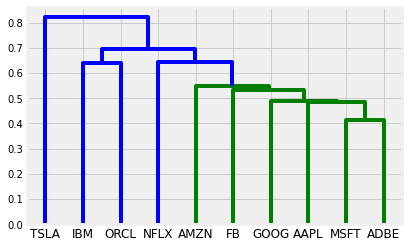

     pcost       dcost       gap    pres   dres
 0: -9.9998e-01 -2.0000e+00  1e+00  1e-15  1e+00
 1: -9.9998e-01 -1.0100e+00  1e-02  1e-16  1e-02
 2: -9.9998e-01 -1.0001e+00  1e-04  8e-17  1e-04
 3: -9.9998e-01 -9.9999e-01  1e-05  2e-16  1e-05
 4: -9.9999e-01 -9.9999e-01  3e-06  3e-16  6e-17
 5: -9.9999e-01 -9.9999e-01  5e-07  1e-16  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9998e-01 -2.0000e+00  1e+00  4e-16  1e+00
 1: -9.9998e-01 -1.0100e+00  1e-02  1e-16  1e-02
 2: -9.9998e-01 -1.0001e+00  1e-04  5e-17  1e-04
 3: -9.9998e-01 -9.9999e-01  1e-05  5e-17  1e-05
 4: -9.9999e-01 -9.9999e-01  3e-06  7e-17  4e-17
 5: -9.9999e-01 -9.9999e-01  5e-07  9e-17  5e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9998e-01 -2.0000e+00  1e+00  4e-16  1e+00
 1: -9.9998e-01 -1.0100e+00  1e-02  1e-16  1e-02
 2: -9.9998e-01 -1.0001e+00  1e-04  7e-17  1e-04
 3: -9.9998e-01 -9.9999e-01  1e-05  4e-17  1e-05
 4: -9.9998e-01 -9.9999e

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys


In [ ]:
portfolios = get_all_portfolios(returns)

In [ ]:
portfolios

,MVP,IVP,HRP
FB,0.001391,0.091199,0.088826
AMZN,0.313225,0.131955,0.110712
AAPL,0.000173,0.094182,0.089643
GOOG,0.110440,0.125388,0.122125
NFLX,0.060202,0.073837,0.061951
TSLA,0.000328,0.024089,0.040477
MSFT,0.000080,0.116318,0.060353
IBM,0.278698,0.123083,0.206822
ORCL,0.235407,0.127069,0.170899
ADBE,0.000056,0.092880,0.048192


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


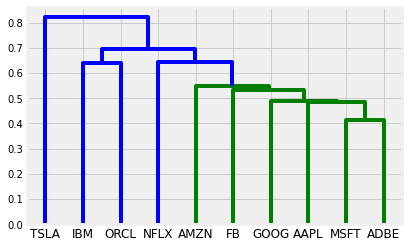

In [ ]:
cov, corr = returns.cov(), returns.corr()
hrp = getHRP(cov, corr)
#link = sch.linkage(correlDist(hrp), 'single')
#sch.dendrogram(link, labels=df_returns.columns, distance_sort='descending', orientation='top')

##Regular Sharpe Ratio Optimized Portfolio

In [ ]:
pip install PyPortfolioOpt

     |████████████████████████████████| 61kB 3.4MB/s 
     |████████████████████████████████| 1.3MB 9.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for cvxpy: filename=cvxpy-1.1.12-cp37-cp37m-linux_x86_64.whl size=2731779 sha256=ed2562bf9d8e46888f5b99d57b9ad7087545a88e7bd687c4757806bc9077ac6e
  Stored in directory: /root/.cache/pip/wheels/9b/62/55/1da181c05c710c5d99bd560edebec3bd6a61cb69acef9dc00e
Successfully built cvxpy
  Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [ ]:
df = close_prices
mu = expected_returns.mean_historical_return(df)#returns.mean() * 252
S = risk_models.sample_cov(df) #Get the sample covariance matrix

In [ ]:
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe() #Maximize the Sharpe ratio, and get the raw weights
cleaned_weights = ef.clean_weights() 
print(cleaned_weights) #Note the weights may have some rounding error, meaning they may not add up exactly to 1 but should be close
ef.portfolio_performance(verbose=True)

OrderedDict([('FB', 0.0), ('AMZN', 0.0), ('AAPL', 0.49066), ('GOOG', 0.0), ('NFLX', 0.0), ('TSLA', 0.50934), ('MSFT', 0.0), ('IBM', 0.0), ('ORCL', 0.0), ('ADBE', 0.0)])
Expected annual return: 133.3%
Annual volatility: 47.6%
Sharpe Ratio: 2.76


(1.3327270444980917, 0.47579590151484874, 2.7590129303733057)

In [ ]:
cleaned_weights

OrderedDict([('FB', 0.0),
             ('AMZN', 0.0),
             ('AAPL', 0.49066),
             ('GOOG', 0.0),
             ('NFLX', 0.0),
             ('TSLA', 0.50934),
             ('MSFT', 0.0),
             ('IBM', 0.0),
             ('ORCL', 0.0),
             ('ADBE', 0.0)])



---



# Calculating Sharpe Ratio (2nd method)

In [ ]:
# importing necessary libraries
import ssl # TLS/SSL wrapper for socket objects
from functools import wraps 
import numpy as np # perform math calculations
import pandas as pd # data analysis
import pandas_datareader.data as web # collect data from resources 
import matplotlib.pyplot as plt # draw graphics

In [ ]:
# setting up connection
def sslwrap(func):
    @wraps(func)
    def bar(*args, **kw):
        kw['ssl_version'] = ssl.PROTOCOL_TLSv1
        return func(*args, **kw)
    return bar
ssl.wrap_socket = sslwrap(ssl.wrap_socket)

In [ ]:
# calculate mean daily return and covariance of daily returns
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()

# set number of runs of random portfolio weights
num_portfolios = 10000
 
# set up array to hold results
# Array to hold weight for each stock
results = np.zeros((3+len(assets),num_portfolios))

In [ ]:
for i in range(num_portfolios):
    # select random weights for portfolio holdings
    weights = np.array(np.random.random(10))
    # normalizing weights
    weights /= np.sum(weights)
 
    # calculate portfolio return and volatility(which is a standard deviation)
    portfolio_return = np.sum(mean_daily_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))*np.sqrt(252)
 
    # store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    # store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
    results[2,i] = ( results[0,i] )/ (results[1,i] )
    # iterate through the weight vector and add data to results array
    for j in range(0,10):
        results[j+3,i] = weights[j]

           ret     stdev    sharpe  ...       IBM      ORCL      ADBE
0     0.541253  0.311578  1.737138  ...  0.095324  0.043920  0.157528
1     0.461553  0.285804  1.614929  ...  0.049624  0.150377  0.007149
2     0.545032  0.308818  1.764898  ...  0.122646  0.004576  0.215383
3     0.503195  0.295843  1.700886  ...  0.058981  0.155020  0.054940
4     0.483827  0.298743  1.619543  ...  0.188849  0.009037  0.181459
...        ...       ...       ...  ...       ...       ...       ...
9995  0.450327  0.280469  1.605624  ...  0.119053  0.063701  0.054240
9996  0.596092  0.326679  1.824704  ...  0.008672  0.069112  0.087410
9997  0.331211  0.258266  1.282443  ...  0.224315  0.204496  0.081279
9998  0.410589  0.275943  1.487947  ...  0.174590  0.095730  0.079205
9999  0.550655  0.320521  1.718002  ...  0.067747  0.026224  0.067601

[10000 rows x 13 columns]


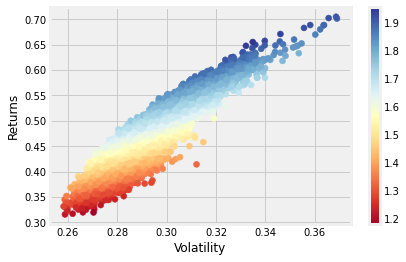

In [ ]:
results_frame = pd.DataFrame(results.T, columns=['ret','stdev','sharpe',assets[0], assets[1], 
                                                 assets[2], assets[3], assets[4], assets[5], 
                                                 assets[6], assets[7], assets[8], assets[9]])
# locate position of portfolio with highest Sharpe Ratio
maxsp = results_frame.iloc[results_frame[['sharpe']].idxmax()]
# locate positon of portfolio with minimum standard deviation
minvp = results_frame.iloc[results_frame['stdev'].idxmin()]
print(results_frame)
# create scatter plot coloured by Sharpe Ratio
plt.scatter(results_frame.stdev,results_frame.ret,c = results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()

In [ ]:
maxsp_array = pd.DataFrame.to_numpy(maxsp) # converting DataFrame to numpy for convenience

In [ ]:
# print the line that was chosen as a max Sharpe Ratio
maxsp

,ret,stdev,sharpe,FB,AMZN,AAPL,GOOG,NFLX,TSLA,MSFT,IBM,ORCL,ADBE
5934,0.655438,0.334872,1.957279,0.080892,0.159303,0.235033,0.125475,0.009099,0.242085,0.037267,0.032898,0.064871,0.013077


In [ ]:
# weights for each company in portfolio
print("FB: ", np.round(maxsp_array[0][3],6)," / AMZN: ", np.round(maxsp_array[0][4],6), 
      " / AAPL: ", np.round(maxsp_array[0][5],6), " / GOOG: ", np.round(maxsp_array[0][6],6),'\n'
      "NFLX: ", np.round(maxsp_array[0][7],6), " / TSLA: ", np.round(maxsp_array[0][8],6),
      " / MSFT: ", np.round(maxsp_array[0][9],6), " / IBM: ", np.round(maxsp_array[0][10],6),'\n'
      "ORCL: ", np.round(maxsp_array[0][11],6), " / ABDE: ", np.round(maxsp_array[0][12],6))

FB:  0.080892  / AMZN:  0.159303  / AAPL:  0.235033  / GOOG:  0.125475 
NFLX:  0.009099  / TSLA:  0.242085  / MSFT:  0.037267  / IBM:  0.032898 
ORCL:  0.064871  / ABDE:  0.013077


In [ ]:
print("Expected portfolio return: ", np.round(100*maxsp_array[0][0],2), "%")
print("Expected portfolio volatility: ", np.round(100*np.average(minvp),2), "%")
print("Maximum Sharpe ration of the portfolio: ", np.round(np.max(results[2]),2))

Expected portfolio return:  65.54 %
Expected portfolio volatility:  22.09 %
Maximum Sharpe ration of the portfolio:  1.96


In [ ]:
weigh_2sr = maxsp.drop({"ret", "stdev", "sharpe"}, axis=1).transpose()
weigh_2sr.rename(columns = {weigh_2sr.columns[0]: 'weight'}, inplace = True)
weigh_2sr = weigh_2sr['weight']
#weigh_2sr = pd.Series(weigh_2sr.columns[0])
weigh_2sr

FB      0.080892
AMZN    0.159303
AAPL    0.235033
GOOG    0.125475
NFLX    0.009099
TSLA    0.242085
MSFT    0.037267
IBM     0.032898
ORCL    0.064871
ADBE    0.013077
Name: weight, dtype: float64



---



#Comparison between HRP and Sharpe Ratio


In [ ]:
print("HRP")
get_calc(hrp)

HRP
Expected annual return : 37.0%
Annual volatility/standard deviation/risk : 31.0%
Annual variance : 10.0%


In [ ]:
sharpe_w  = pd.Series(cleaned_weights,index=cleaned_weights.keys())
print("Sharpe Ratio")
get_calc(sharpe_w)

Sharpe Ratio
Expected annual return : 98.0%
Annual volatility/standard deviation/risk : 48.0%
Annual variance : 23.0%


In [ ]:
print("Sharpe Ratio Second Method")
get_calc(weigh_2sr)

Sharpe Ratio Second Method
Expected annual return : 66.0%
Annual volatility/standard deviation/risk : 33.0%
Annual variance : 11.0%


###Additional

In [ ]:
ivp = getIVP(cov)
ivp = pd.Series(ivp, index=cov.index)

mvp = getMVP(cov)
mvp = pd.Series(mvp, index=cov.index)


     pcost       dcost       gap    pres   dres
 0: -9.9998e-01 -2.0000e+00  1e+00  1e-15  1e+00
 1: -9.9998e-01 -1.0100e+00  1e-02  1e-16  1e-02
 2: -9.9998e-01 -1.0001e+00  1e-04  8e-17  1e-04
 3: -9.9998e-01 -9.9999e-01  1e-05  2e-16  1e-05
 4: -9.9999e-01 -9.9999e-01  3e-06  3e-16  6e-17
 5: -9.9999e-01 -9.9999e-01  5e-07  1e-16  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9998e-01 -2.0000e+00  1e+00  4e-16  1e+00
 1: -9.9998e-01 -1.0100e+00  1e-02  1e-16  1e-02
 2: -9.9998e-01 -1.0001e+00  1e-04  5e-17  1e-04
 3: -9.9998e-01 -9.9999e-01  1e-05  5e-17  1e-05
 4: -9.9999e-01 -9.9999e-01  3e-06  7e-17  4e-17
 5: -9.9999e-01 -9.9999e-01  5e-07  9e-17  5e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9998e-01 -2.0000e+00  1e+00  4e-16  1e+00
 1: -9.9998e-01 -1.0100e+00  1e-02  1e-16  1e-02
 2: -9.9998e-01 -1.0001e+00  1e-04  7e-17  1e-04
 3: -9.9998e-01 -9.9999e-01  1e-05  4e-17  1e-05
 4: -9.9998e-01 -9.9999e

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


In [ ]:
print("Traditional risk parity’s Inverse-Variance Portfolio (IVP)")
get_calc(ivp)
print()
print("Markowitz’s Minimum-Variance Portfolio (MVP)")
get_calc(mvp)

Traditional risk parity’s Inverse-Variance Portfolio (IVP)
Expected annual return : 39.0%
Annual volatility/standard deviation/risk : 27.0%
Annual variance : 7.000000000000001%

Markowitz’s Minimum-Variance Portfolio (MVP)
Expected annual return : 28.000000000000004%
Annual volatility/standard deviation/risk : 25.0%
Annual variance : 6.0%
